# Computationnal Statistics - TP2

**BLANCHARD Théau**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import norm

# Exercise 1
## Question 2

In [2]:
def simp(P,X):
    """
    P : Probability vector
    X : Values to sample from
    """
    C = np.cumsum(P)/np.sum(P)
    u= np.random.random()
    i = np.argmax(C>u)
    return X[i]

In [3]:
# Generate the distribution
n = 10
P = np.random.random(n)
P = P/np.sum(P)
X = np.arange(0,10)

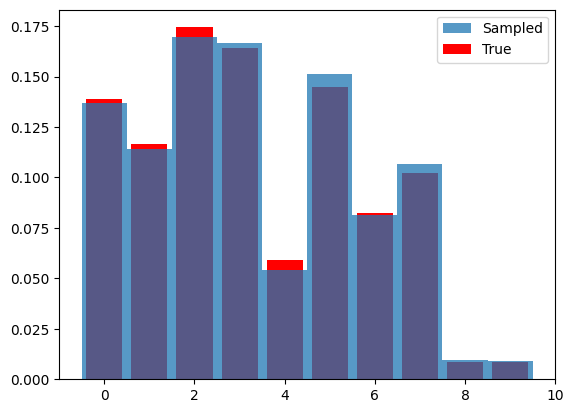

In [4]:
# Sample from the distribution
n_ech = int(1E4)
X_ech = []
for i in range(n_ech):
    X_ech.append(simp(P,X))

# Plot the result
plt.bar(X,P,color='r',label='True',align="center")
plt.hist(X_ech,bins=np.arange(0,11),density=True,alpha=0.75,align="left",label="Sampled")
plt.legend()
plt.show()

It seems to work well.

# Exercice 2

## Question 2

In [5]:
# Generate the distribution
nb_cluster = 4
alphas = np.random.random(size=nb_cluster)
alphas /= alphas.sum()

mus = np.array([[0,0],[-15,-8],[3,3],[-4,4]])
sigmas = [np.identity(2) for _ in range(nb_cluster-1)]
sigmas.append(np.array([
        [0.12,0.8],
        [0.33,7.]
]))


gaussians = []

for idx_cluster in range (nb_cluster) :
    gaussians.append(multivariate_normal(mean=mus[idx_cluster], cov=sigmas[idx_cluster], allow_singular=False))

print(alphas)

[0.50147018 0.14397563 0.2675481  0.08700609]


In [6]:
# Sample points
n_ech = 4000
X_ech = []
Z_ech = []
for i in range(n_ech):
    z = simp(alphas,np.arange(nb_cluster))
    X_ech.append(multivariate_normal.rvs(mus[z],sigmas[z]))
    Z_ech.append(z)
X_ech = np.array(X_ech)

c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_multivariate.py:657: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [7]:
# Disclaimer : these two functions are not mine

def compute_contour(rv,xmin, xmax, ymin, ymax, n_points=200):
    x = np.array(np.meshgrid(np.linspace(xmin, xmax, n_points), np.linspace(ymin, ymax, n_points)))
    x = x.reshape(2, n_points*n_points)
    z = np.zeros(n_points*n_points)
    for i in range(n_points*n_points):
        z[i] = rv.pdf(x[:,i])
    x = x.reshape(2, n_points, n_points)
    z = z.reshape(n_points, n_points)
    
    return x, z

def plot_distrib(X_ech,Z_ech,gaussians,title="",range_values = None,levels=None, n_points = 200, box = None):
    nb_cluster = len(gaussians)
    fig = plt.figure()
    ax = plt.gca()
    sns.scatterplot(data=pd.DataFrame(X_ech),x=0,y=1,hue=Z_ech,style=Z_ech,s=30)
    if range_values is None :
        xmin, xmax = X_ech[:,0].min(), X_ech[:,0].max()
        ymin, ymax = X_ech[:,1].min(), X_ech[:,1].max()
    else :
        xmin, xmax, ymin, ymax = range_values
    for j in range(nb_cluster):
        x, z = compute_contour(gaussians[j],xmin, xmax, ymin, ymax, n_points=n_points)
        ax.contour(x[0], x[1], z,levels = levels)
        ax.scatter(gaussians[j].mean[0],gaussians[j].mean[1])
    if box :
        ax.set_box_aspect(box)
    ax.set_title(title)

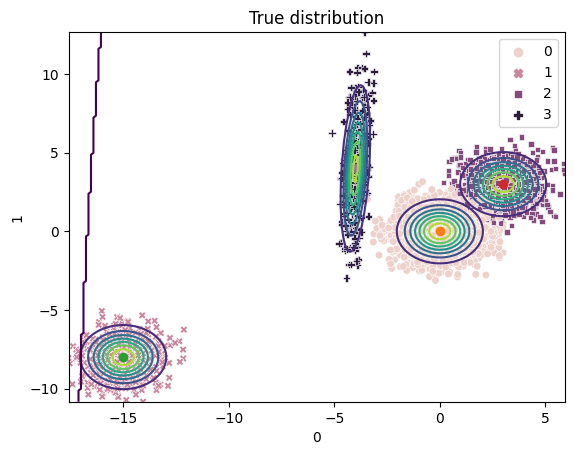

In [8]:
plot_distrib(X_ech,Z_ech,gaussians,title="True distribution")

## Question 3

### Step E

In [9]:
def E_step(alphas_curr,gaussians_curr,X):
    """Computes the tau_{i,j} given the current estimate of the weights alpha_curr
       and the distributions gaussians_curr"""
    epsilon = 0.0000000000001
    m = len(gaussians_curr)
    n, _ = X.shape

    if m>1 :
        tau = alphas_curr[0] * gaussians_curr[0].pdf(X)
        for k in range(1,m):
            tau_k = alphas_curr[k] * gaussians_curr[k].pdf(X)
            tau = np.c_[tau,tau_k]
        tau_sum = tau.sum(axis=1)
        tau_sum = np.where(tau_sum==0.,epsilon,tau_sum)
        tau = tau / tau_sum[:,np.newaxis]

    elif m == 1 :
        tau = np.ones(n)
        
    tau = tau.reshape(-1,m)

    return tau

### Step M

In [10]:
def M_step(tau,X,nb_cluster):
    """Update the gaussians"""
    epsilon = 0.000000001
    n, dim = X.shape

    #New parameter
    mu_next = np.zeros((nb_cluster,dim))
    sigmas_next = np.zeros((nb_cluster,dim,dim))
    
    
    # Update of the parameters
    if nb_cluster > 1 :
        alphas_next = tau.mean(axis=0)
    else :
        alphas_next = tau

    tau_sum = tau.sum(axis=0)
    tau_sum = np.where(tau_sum==0.,epsilon,tau_sum)
    for k in range(nb_cluster):

        mu_next[k] = np.sum(tau[:,k].reshape(n,1)*X,axis=0)/tau_sum[k]
        for i in range(n):
            Xi_muk = (X[i] - mu_next[k]).reshape(-1,1)
            sigmas_next[k] += tau[i,k] * Xi_muk @ Xi_muk.T
        sigmas_next[k] /= tau_sum[k]

    # Reconstruction of the gaussians
    gaussians_next = []
    for k in range(nb_cluster):
        # We allow singular matrix for computation purposes
        gaussians_next.append(multivariate_normal(mu_next[k],sigmas_next[k],allow_singular=True))

    return alphas_next,gaussians_next
    

### EM algorithm

In [11]:
def param_initialisation(nb_cluster,X,type="kmeans"):
    
    _, dim = X.shape

    alphas_0 = np.ones(nb_cluster)
    alphas_0 /= alphas_0.sum()

    # I pick the means using a KMeans clustering but it is slower when there are many samples
    if type=="kmeans":
        from sklearn.cluster import KMeans
        mu_0 = KMeans(n_clusters = nb_cluster).fit(X).cluster_centers_
    # Otherwise I pick randoms points within the range of the samples
    else : 
        mu_0 = (X.max() - X.min()) * np.random.random(size=(nb_cluster,dim)) + X.min()
    # I set the covariance matrix to the identity because it's easier
    # We could use a covariance estimation for each class given by the kmeans, it's likely to be less efficient tho... 
    sigmas_0 = [np.identity(dim) for _ in range(nb_cluster)]
    gaussians_0 = []

    for k in range(nb_cluster):
        gaussians_0.append(multivariate_normal(mu_0[k],sigmas_0[k]))
        
    return alphas_0,gaussians_0

def log_likelihood(X,alphas,gaussians):
    n, dim = X.shape
    epsilon = 0.00000000001
    nb_cluster = len(gaussians)
    res = 0

    for i in range(n):
        f_i = 0
        for k in range(nb_cluster):
            f_i += alphas[k]* gaussians[k].pdf(X[i])
        # Again, if the  estimation is very bad for a given point,
        # the pdf will be almost zero for all gaussians. Thus the epsilon.
        res += np.log(f_i+epsilon)

    return res


def EM_algorithm_one_shot(X, nb_cluster, max_iter = 10, init_type="kmeans", show= False, Z_ech = None, display_freq = 5):
    """
    Computes the EM algorithm for `max_iter` iterations.
    """

    alphas_next, gaussians_next = param_initialisation(nb_cluster,X,init_type)
    log_likelihood_est = []
    log_likelihood_est.append(log_likelihood(X,alphas_next,gaussians_next)) # Initial guess

    if show: 
        plot_distrib(X,Z_ech,gaussians_next,title="Initialization")
        plt.show()

    for l in range(max_iter):

        tau = E_step(alphas_next,gaussians_next,X)
        alphas_next,gaussians_next = M_step(tau,X,nb_cluster)

        log_likelihood_est.append(log_likelihood(X,alphas_next,gaussians_next))

        if show and (l+1)%display_freq == 0:
            plot_distrib(X,Z_ech,gaussians_next,title="Iteration {0}".format(l+1))
            plt.show()

        
    log_likelihood_est.append(log_likelihood(X,alphas_next,gaussians_next)) # Final guess

    if show :
        plot_distrib(X,Z_ech,gaussians_next,title="Final estimation",levels=5)
        plt.show()
        
    return alphas_next,gaussians_next,log_likelihood_est


def EM_algorithm(X, nb_cluster, nb_lunch = 3, max_iter = 10, init_type="kmeans",verbose = False, show= False, Z_ech = None, display_freq = 5):
    """Lunch the EM_algorithm several times with different initialization.
       Returns the estimate that achieves max loglikelihood."""

    best_log = -np.inf
    curr_it = 0
    res = None

    while curr_it < nb_lunch : 
        alphas_curr, gaussians_curr, log_curr = EM_algorithm_one_shot(X,nb_cluster,max_iter ,init_type,show,Z_ech,display_freq)
        if verbose : print("Lunch number",curr_it,". Log-likelihood :",log_curr[-1],"\n")
        if log_curr[-1] > best_log :
            best_log = log_curr[-1]
            res = alphas_curr, gaussians_curr, log_curr
        curr_it += 1
    
    return res

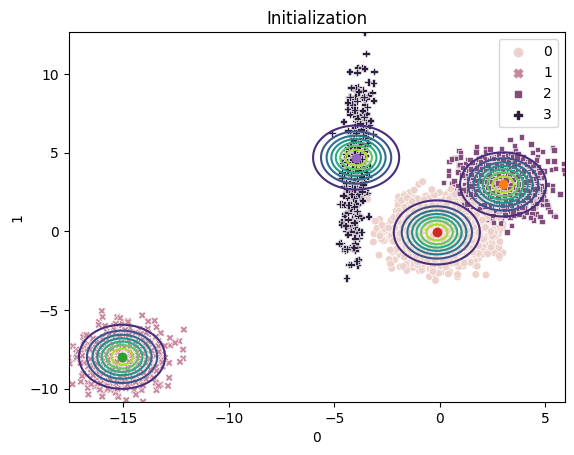

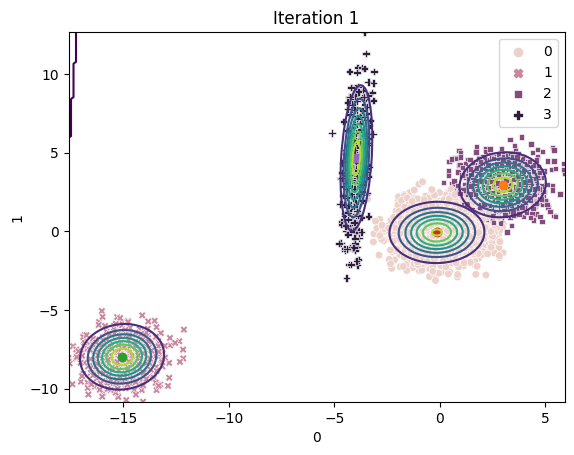

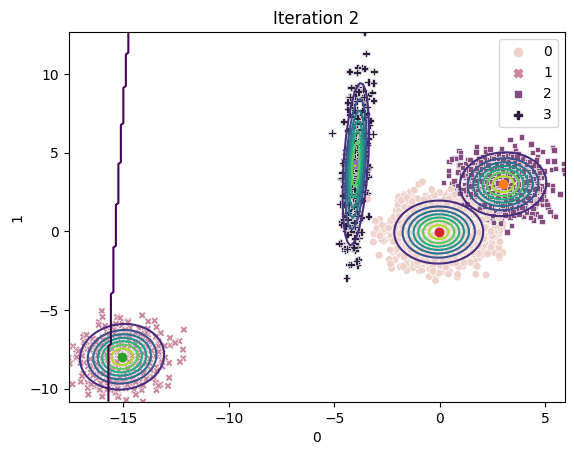

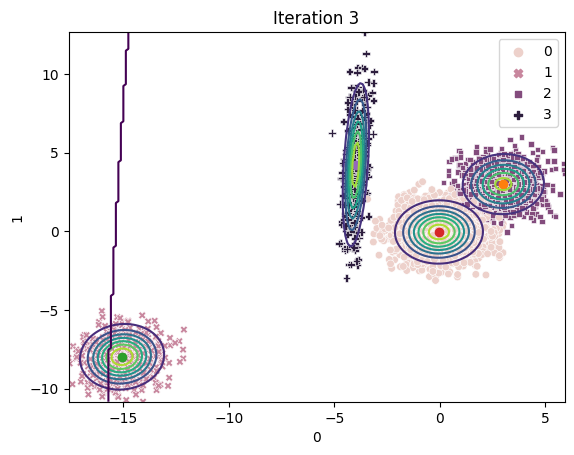

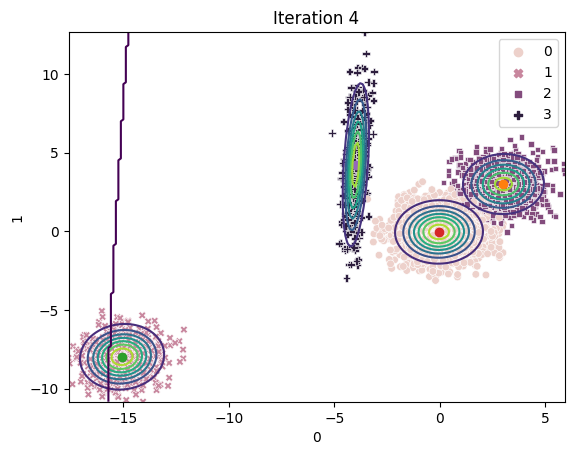

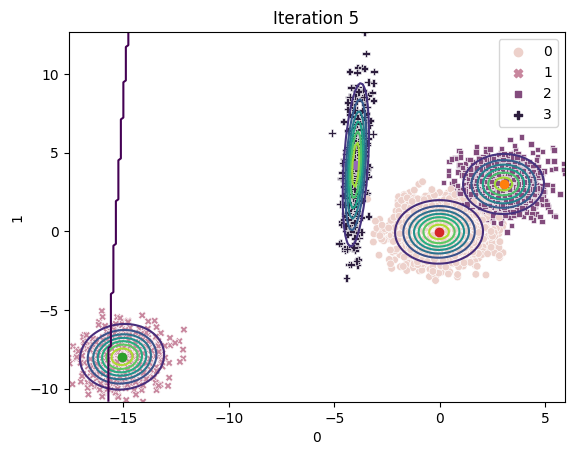

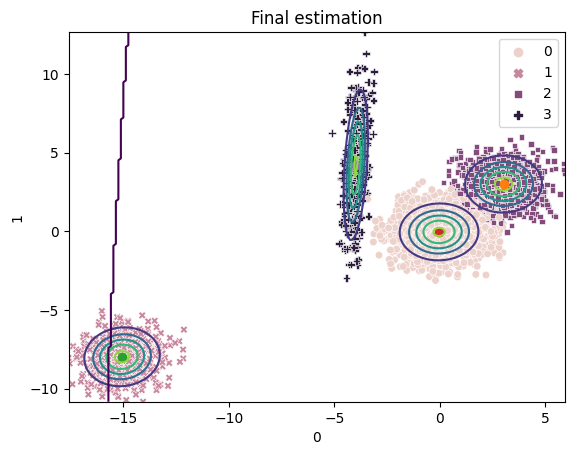

Lunch number 0 . Log-likelihood : -15982.383867756162 



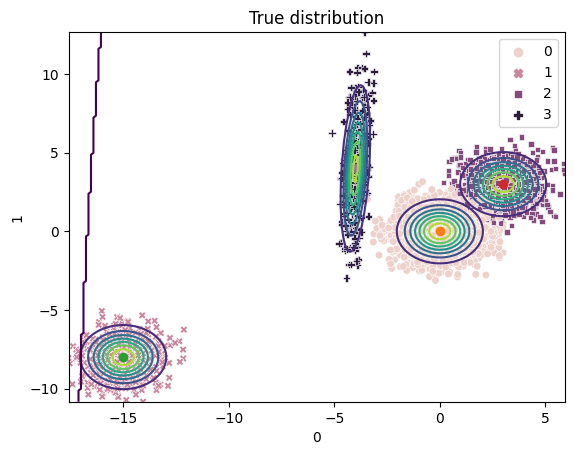

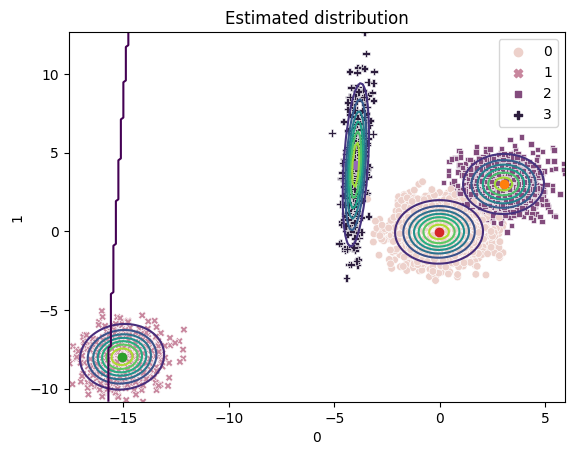

In [12]:
alphas_est, gaussians_est, log_est = EM_algorithm(X_ech,nb_cluster=4,nb_lunch= 1,max_iter = 5, init_type="kmeans",verbose = True,show=True,Z_ech=Z_ech,display_freq=1)

plot_distrib(X_ech,Z_ech,gaussians,title="True distribution")
plt.show()
plot_distrib(X_ech,Z_ech,gaussians_est,title="Estimated distribution")

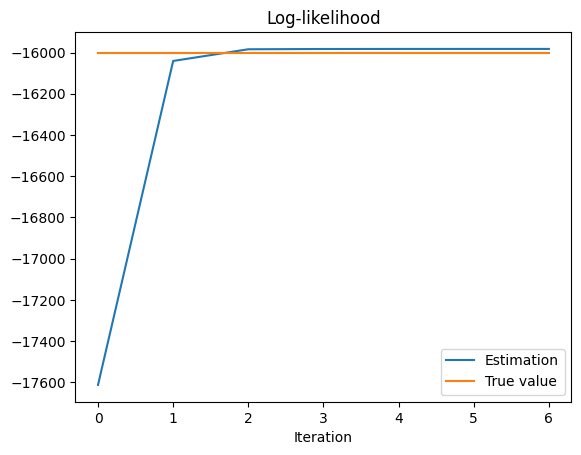

In [13]:
plt.plot(log_est,label="Estimation")
plt.plot([0,len(log_est)-1],[log_likelihood(X_ech,alphas,gaussians),log_likelihood(X_ech,alphas,gaussians)],label="True value")
plt.title("Log-likelihood")
plt.xlabel("Iteration")
plt.legend()
plt.show()

## Question 4

We can see that the algorithms converges in terms of log-likelihood in a very small number of steps. Furthermore, it seems to converge towards the true underlying distribution of the data.

## Question 5

In [14]:
data = pd.read_csv("./Data/Crude-BirthDeath-Rate.csv")
data

,Birth,Death
0,53.1,22.6
1,28.1,8.5
2,45.1,9.3
3,50.0,23.7
4,30.6,8.8
...,...,...
189,39.6,12.7
190,39.2,9.1
191,32.6,8.3
192,40.7,10.4


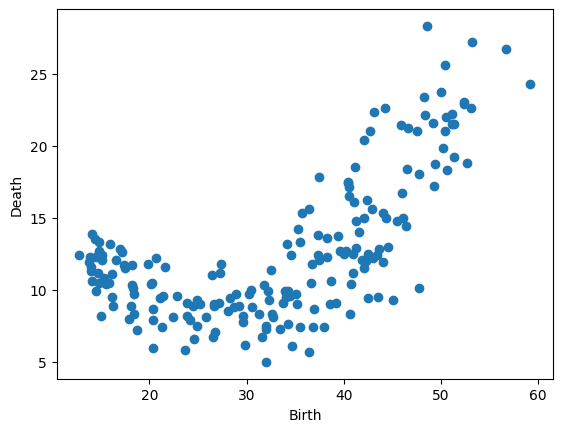

In [15]:
plt.scatter(data["Birth"],data["Death"])
plt.xlabel("Birth")
plt.ylabel("Death")
plt.show()

The data does not seem to follow a GM model but still, given a sufficient number of gaussians, it seems reasonable to use such a model.

## Question 6

In [16]:
data = data.to_numpy()

In [17]:
def BIC(X,gaussians,alphas):
    n, dim = X.shape
    m =len(gaussians)
    # alpha -> m-1 because the sum is 1
    # mu -> m*dim
    # sigma -> m* dim*(dim+1)/2 because covariance matrices are symmetric
    df = m*dim + m-1 + m* (dim*(dim+1)//2) 
    return float(-log_likelihood(X,alphas,gaussians) + df*np.log(n)/2)

In [18]:
def BIC_estimation(nb_cluster_max,X,nb_lunch = 3, max_iter = 10, show_all = False, show_final = True, verbose = False):
    """ 
    Returns the number of cluster. that minimizes the BIC alongside the 
    paramters for this number of clusters.
    """

    BIC_values = []
    estimated_param = []

    for m in range(nb_cluster_max):
        print(m+1,"clusters")
        alphas_est, gaussians_est, log_est = EM_algorithm(X,m+1,nb_lunch, max_iter, verbose,)
        
        estimated_param.append((alphas_est, gaussians_est, log_est))
        BIC_values.append(BIC(X,gaussians_est,alphas_est))
        print("BIC =",BIC_values[-1])
        
        if show_all :
            plot_distrib(X,None,gaussians_est,title="Number of cluster : {0}.".format(m+1),range_values = (-5,80,0,40),n_points=500,box=1)
            plt.show()
        
    
    best_m = np.argmin(BIC_values)
    alphas_est, gaussians_est, log_est = estimated_param[best_m]

    if show_final :
        plot_distrib(X,None,gaussians_est,title="Best estimation. Number of cluster : {0}.".format(best_m+1),range_values = (-5,80,0,40),n_points=500,box=1)
        plt.show()   
             
    return alphas_est, gaussians_est, log_est, BIC_values, best_m+1

1 clusters
BIC = 1302.5180005468967


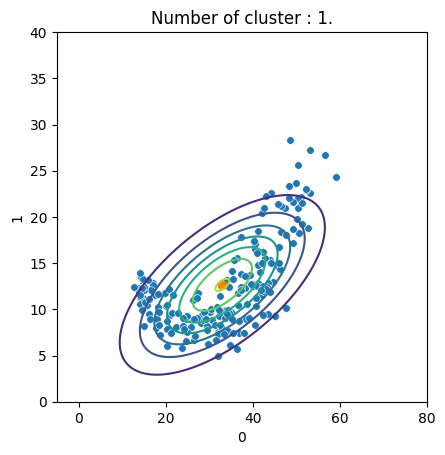

2 clusters
BIC = 1215.4506848702401


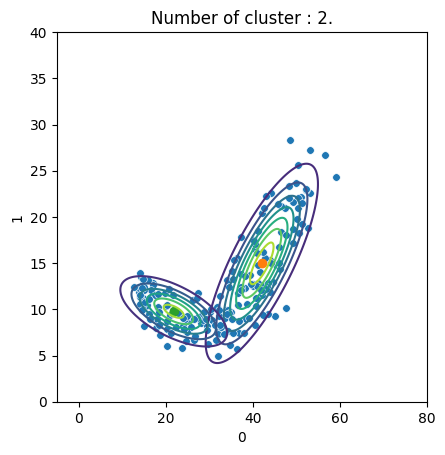

3 clusters


ValueError: The input matrix must be symmetric positive semidefinite.

In [19]:
alphas_est, gaussians_est, log_est,BIC_values, best_m = BIC_estimation(4,data,nb_lunch = 20, max_iter = 30, show_all = True, show_final = True)


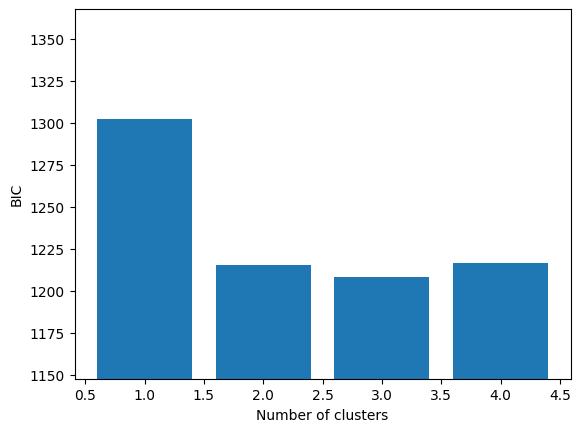

In [ ]:
plt.bar(np.arange(1,len(BIC_values)+1),BIC_values)
plt.ylabel("BIC")
plt.xlabel("Number of clusters")
plt.ylim(np.min(BIC_values)*0.95)
plt.show()

# Exercise 3

## Question 1

In [ ]:
def f(x):
    return np.where(x>0,2*np.sin(np.pi/1.5 * x),0)

def p(x):
    return np.where(x>0,np.power(x,0.65)*np.exp(-np.square(x)/2),0)

def q(mu,sigma):
    return norm(mu,sigma)

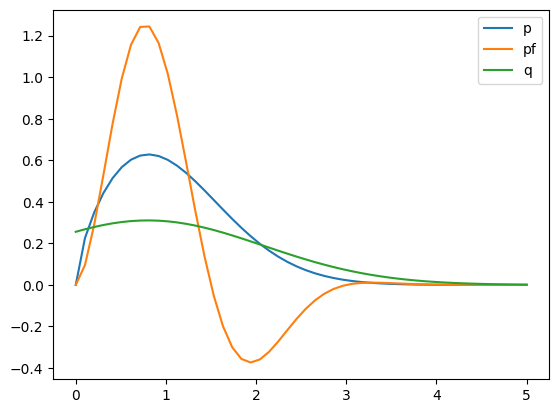

In [ ]:
t = np.linspace(0,5)
q_plot = q(0.8,np.sqrt(1.65)).pdf(t)
p_plot = p(t)
f_plot = f(t)

plt.plot(t,p_plot,label='p')
plt.plot(t,p_plot*f_plot,label="pf")
plt.plot(t,q_plot,label='q')
#plt.plot(f_plot,label='f')
plt.legend()
plt.show()

In [ ]:
def importance_sampling(mu,sigma,n):
    # Get a n_sample from q
    X_sample = []
    for _ in range(n):
        sample = norm.rvs(mu,sigma)
        if sample>=0:
            X_sample.append(sample)
    # So as to have easier visualization later-on we sort the values
    X_sample = np.sort(np.array(X_sample))

    w_i = p(X_sample)/q(mu,sigma).pdf(X_sample)
    w_i = w_i / np.mean(w_i)

    E = (w_i*f(X_sample)).mean()
    V = (1/n*w_i*f(X_sample)).std()**2
    print("Expectation and variance :",E,V)
    return E,V,w_i,X_sample

## Question 2

In [ ]:
# Sanity check
import scipy.integrate as integrate
result = integrate.quad(lambda x: f(x)*p(x), 0, 10)
print("We should get around",result[0])

We should get around 0.7752953044231231


In [ ]:
for N in [10,100,1000,10000,int(1E5)]:
    print(f"{N = }")
    importance_sampling(0.8,np.sqrt(1.5),N)

N = 10
Expectation and variance : 0.555295841482726 0.013113902619145494
N = 100
Expectation and variance : 0.30937259704424375 0.000189049343489185
N = 1000
Expectation and variance : 0.7345476518940067 2.0401812275722887e-06
N = 10000
Expectation and variance : 0.7727418513835725 2.0635540784045343e-08
N = 100000
Expectation and variance : 0.7755802917437669 2.0448564517445177e-10


We get acceptable result.

## Question 3

In [ ]:
for N in [10,100,1000,10000,int(1E5)]:
    print(f"{N = }")
    importance_sampling(6,np.sqrt(1.5),N)

N = 10
Expectation and variance : 1.865444019952943 0.2872381947736556
N = 100
Expectation and variance : -1.9836142585227543 0.03922464916235083
N = 1000
Expectation and variance : -1.4555033696821937 0.0025220298059970376
N = 10000
Expectation and variance : -1.1226062050232197 9.253016805651483e-06
N = 100000
Expectation and variance : 0.389991744010939 1.6708873645164613e-06


The result are really far from the value computed before and very sensible to the number of sample.

## Question 3

In [ ]:
E1, V1, weight_mu1, X_1 = importance_sampling(0.8,np.sqrt(1.5),10000)
E2, V2, weight_mu2, X_2 = importance_sampling(6,np.sqrt(1.5),10000)


Expectation and variance : 0.7796539303630996 2.0793402241451776e-08
Expectation and variance : 0.07751644241871104 2.198565697942736e-05


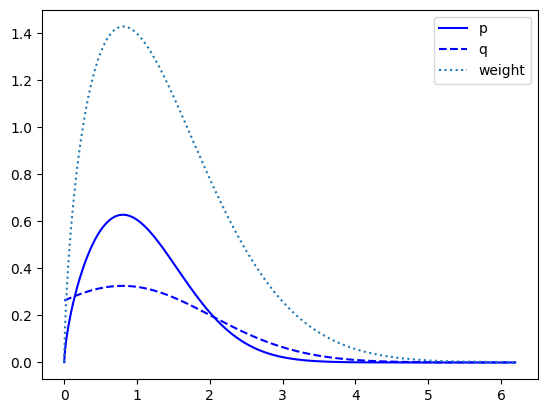

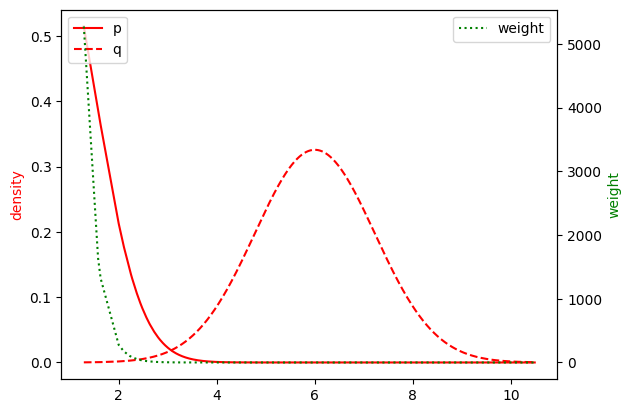

In [ ]:
plt.plot(X_1,p(X_1),c="b",label="p")
plt.plot(X_1,q(0.8,np.sqrt(1.5)).pdf(X_1),c="b",ls="--",label="q")
plt.plot(X_1,weight_mu1,ls=":",label="weight")
plt.legend()
plt.show()


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(X_2,p(X_2),c="r",label="p")
ax1.plot(X_2,q(6,np.sqrt(1.5)).pdf(X_2),c="r",ls="--",label="q")
ax2.plot(X_2,weight_mu2,ls=":",label="weight",c="g")
ax1.set_ylabel('density', color='r')
ax2.set_ylabel('weight', color='g')
ax1.legend(loc=2)
ax2.legend(loc="upper right")

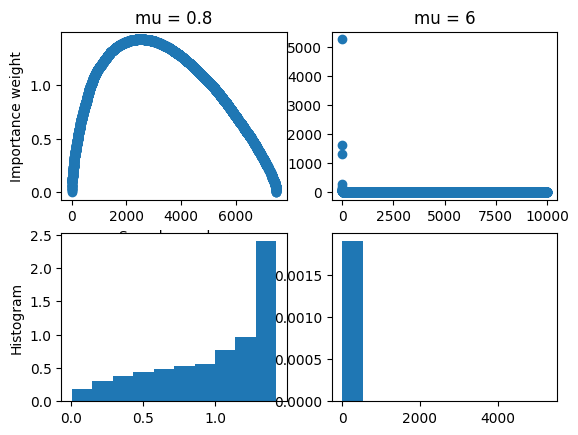

In [ ]:
fig,ax = plt.subplots(2,2)
ax[0,0].scatter([k for k in range(len(weight_mu1))],weight_mu1)
ax[0,0].set_ylabel("Importance weight")
ax[0,0].set_xlabel("Sample number")
ax[0,0].set_title("mu = 0.8")
ax[0,1].scatter([k for k in range(len(weight_mu2))],weight_mu2)
ax[0,1].set_title("mu = 6")

ax[1,0].hist(weight_mu1,density=True)
ax[1,0].set_ylabel("Histogram")
ax[1,1].hist(weight_mu2,density=True)

plt.show()

Because the density $q$ is too far away from $p$, it is not able to properly sample values with $q$ that ressemble those of $p$. Consequently, the weigths are very sparse and the non zero values are very high and localized where the two density meet. All of this leads to a very poor estimation.

## Question 5

In [ ]:
def q(alphas,gaussians,X):
    """
    Pdf of points X given the parameters of the mixture.
    X : (n,d) array
    alphas : (m,) array
    gaussians : (m,) array
    """
    res = 0
    for k in range(len(alphas)):
        res += alphas[k]*gaussians[k].pdf(X)
    return res

def v(x,d,sigma1,b):
    """
    Pdf of a points X on the banana distribution
    X :(n,d) array
    d : dimension
    sigma1 : variance of the first dimension
    """
    l = np.ones(d)
    l[0] = sigma1
    cov = np.diag(l)
    phi = multivariate_normal(np.zeros(d),cov)
    x_skew = np.copy(x)
    x_skew[:,1] += b*(x_skew[:,0]**2-sigma1**2)
    return phi.pdf(x_skew)
    

def sample_from_mixture(alphas,gaussians,n_sample=1000):
    Z = np.random.choice(len(alphas),n_sample,p=alphas)
    X_ech = np.array([gaussians[k].rvs() for k in Z])
    return X_ech
    

In [ ]:
def E_step_MC(alphas_curr,gaussians_curr,X,w_i):
    """Computes the tau_{i,j} given the current estimate of the weights alpha_curr
    ,the distributions gaussians_curr, the sampled points X and the importance weights w_i"""
    epsilon = 0.0000000000001
    m = len(gaussians_curr)
    n, _ = X.shape

    if m>1 :
        tau = alphas_curr[0] * gaussians_curr[0].pdf(X)
        for k in range(1,m):
            tau_k = alphas_curr[k] * gaussians_curr[k].pdf(X)
            tau = np.c_[tau,tau_k]
        tau_sum = tau.sum(axis=1)
        tau_sum = np.where(tau_sum==0.,epsilon,tau_sum)
        tau = tau / tau_sum[:,np.newaxis]

    elif m == 1 :
        tau = np.ones(n)
        
    tau = tau.reshape(-1,m)
    tau = tau*w_i[:,np.newaxis]
    #tau = tau / tau.sum(axis=1)[:,np.newaxis]
    return tau

In [ ]:
def M_step_MC(tau,X,nb_cluster):
    """Update the gaussians"""
    epsilon = 0.000000001
    n, dim = X.shape

    #New parameter
    mu_next = np.zeros((nb_cluster,dim))
    sigmas_next = np.zeros((nb_cluster,dim,dim))
    
    
    # Update of the parameters
    if nb_cluster > 1 :
        alphas_next = tau.mean(axis=0)
    else :
        alphas_next = tau

    tau_sum = tau.sum(axis=0)
    tau_sum = np.where(tau_sum==0.,epsilon,tau_sum)
    for k in range(nb_cluster):

        mu_next[k] = np.sum(tau[:,k].reshape(n,1)*X,axis=0)/tau_sum[k]
        for i in range(n):
            Xi_muk = (X[i] - mu_next[k]).reshape(-1,1)
            sigmas_next[k] += tau[i,k] * Xi_muk @ Xi_muk.T
        sigmas_next[k] /= tau_sum[k]

    # Reconstruction of the gaussians
    gaussians_next = []
    for k in range(nb_cluster):
        # We allow singular matrix for computation purposes
        gaussians_next.append(multivariate_normal(mu_next[k],sigmas_next[k],allow_singular=True))

    return alphas_next,gaussians_next
    

In [ ]:
def EM_algorithm_MC(X, nb_cluster,w_i, max_iter = 10, init_type="kmeans", show= False, Z_ech = None, display_freq = 5):
    """
    Computes the EM algorithm for `max_iter` iterations given some sampled points X, the number of clusters nb_cluster and the importance weights w_i.
    """

    alphas_next, gaussians_next = param_initialisation(nb_cluster,X,init_type)
    log_likelihood_est = []
    log_likelihood_est.append(log_likelihood(X,alphas_next,gaussians_next)) # Initial guess

    if show: 
        plot_distrib(X,Z_ech,gaussians_next,title="Initialization")
        plt.show()

    for l in range(max_iter):
        
        tau = E_step_MC(alphas_next,gaussians_next,X,w_i)
        alphas_next,gaussians_next = M_step_MC(tau,X,nb_cluster)

        ## We need to normalize the alphas
        alphas_next = alphas_next/alphas_next.sum()

        log_likelihood_est.append(log_likelihood(X,alphas_next,gaussians_next))

        if show and (l+1)%display_freq == 0:
            plot_distrib(X,Z_ech,gaussians_next,title="Iteration {0}".format(l+1))
            plt.show()
            
    log_likelihood_est.append(log_likelihood(X,alphas_next,gaussians_next)) # Final guess

    if show :
        plot_distrib(X,Z_ech,gaussians_next,title="Final estimation",levels=5)
        plt.show()
        
    return alphas_next,gaussians_next,log_likelihood_est

In [ ]:
def population_monte_carlo(v,d,sigma1,b,nb_cluster,nb_iter = 5,show=False):
    """Compute the estimate of the population monte carlo algorithm v for nb_cluster clusters in dimension d on nb_iter iterations"""
    
    # (i) Choose mixture parameters
    # In ordre to initialize the algorithm, we use data uniformly sampled from the unirform distribution on the unit cube centered on the origin.
    X0 = 2*np.random.random(size=(1000,d))-1
    alphas_next, gaussians_next = param_initialisation(nb_cluster,X0)

    KL_proxy = []
    for curr_it in range(nb_iter):
        print("Iteration",curr_it)

        if show:
            X_sample = sample_from_mixture(alphas_next,gaussians_next,2500)
            plt.scatter(X_sample[:,0],X_sample[:,1])
            plt.title("iteration {0}".format(curr_it))
            plt.show()

        # (ii) Compute normalized weights
        
            ## Sample from the mixture 
        n_samples = 1000
        X_ech = sample_from_mixture(alphas_next,gaussians_next,n_samples)
        


            ## Compute the weights
        q_X = q(alphas_next,gaussians_next,X_ech)
        v_X = v(X_ech,d,sigma1,b)
        w_i = v_X/q_X
        w_i = w_i/np.sum(w_i)
        
        # (iii) Maximize parameters
        alphas_next,gaussians_next,log_est = EM_algorithm_MC(X_ech,nb_cluster,w_i)
        KL_proxy.append(log_est[-1])
    return alphas_next,gaussians_next,KL_proxy

In [ ]:
sigma1= 2
d = 5
b = 0.4
nb_cluster = 5
nb_iter = 20

In [ ]:
alphas_next,gaussians_next,KL_proxy = population_monte_carlo(v,d,sigma1,b,nb_cluster,nb_iter)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


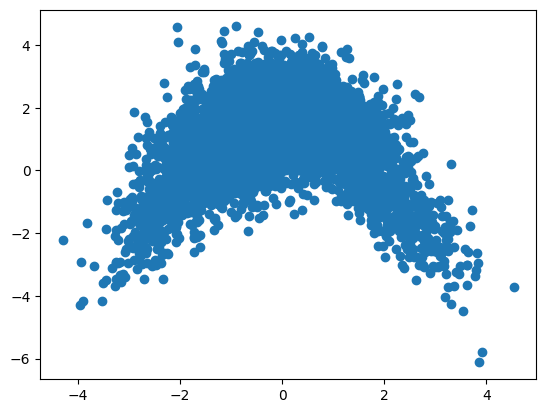

In [ ]:
X_sample = sample_from_mixture(alphas_next,gaussians_next,5000)
plt.scatter(X_sample[:,0],X_sample[:,1])
plt.box(True)
plt.show()